In [ ]:
import os
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image
import numpy as np
from torchvision.transforms import functional as F
import torchvision.transforms as T
import time
from collections import defaultdict
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from roboflow import Roboflow
import shutil
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [2]:
ROBOFLOW_API_KEY = 'jB1GONZlnhURZN4VHkCt'
if ROBOFLOW_API_KEY is None:
    print("Error: ROBOFLOW_API_KEY not found in environment variables. Please set it in your .env file.")


def download_dataset(api_key: str, workspace: str, project: str, version: int, format: str, target_dir: str):
    """
    Downloads the dataset from Roboflow.

    Args:
        api_key (str): Roboflow API key.
        workspace (str): The name of Roboflow workspace.
        project (str): The name of Roboflow project.
        version (int): The version number of the dataset to download.
        format (str): The desired format for the downloaded dataset.
        target_dir (str): The directory where the dataset will be saved.
    """
    print(f"Attempting to download dataset '{workspace}/{project} v{version}' to '{target_dir}'...")
    rf = Roboflow(api_key=api_key)
    proj = rf.workspace(workspace).project(project)
    dataset = proj.version(version).download(format, location=target_dir)
    print(f"Dataset '{workspace}/{project} v{version}' downloaded to: {dataset.location}")
    return dataset.location


def _merge_coco_split_data(ds1_ann_path, ds1_img_dir, ds2_ann_path, ds2_img_dir, merged_ann_path, merged_img_dir):
    """Merges annotation data and images from two COCO dataset splits into a single new split.

    Handles merging of categories (ensuring uniqueness), re-indexing of image and annotation IDs
    to avoid conflicts, and copying of image files. If an annotation or image directory for a
    source dataset split is not found or is empty, it will be skipped for that part of the merge.

    Args:
        ds1_ann_path (str | None): Path to the COCO annotation JSON file for the first dataset's split.
                                   Can be None if this split doesn't exist for dataset 1.
        ds1_img_dir (str | None): Path to the image directory for the first dataset's split.
                                  Can be None if this split doesn't exist for dataset 1.
        ds2_ann_path (str | None): Path to the COCO annotation JSON file for the second dataset's split.
                                   Can be None if this split doesn't exist for dataset 2.
        ds2_img_dir (str | None): Path to the image directory for the second dataset's split.
                                  Can be None if this split doesn't exist for dataset 2.
        merged_ann_path (str): Path where the merged COCO annotation JSON file will be saved.
        merged_img_dir (str): Path to the directory where images from both datasets will be copied for the merged split.

    Returns:
        None: This function writes the merged annotation file and copies images directly.
    """
    print(f"Merging split: {ds1_ann_path} and {ds2_ann_path} into {merged_ann_path}")

    if not os.path.exists(ds1_ann_path):
        print(f"Warning: Annotation file not found {ds1_ann_path}, skipping merge for this part of ds1.")
        data1 = {'images': [], 'annotations': [], 'categories': []}
    else:
        with open(ds1_ann_path, 'r') as f:
            data1 = json.load(f)

    if not os.path.exists(ds2_ann_path):
        print(f"Warning: Annotation file not found {ds2_ann_path}, skipping merge for this part of ds2.")
        data2 = {'images': [], 'annotations': [], 'categories': []}
    else:
        with open(ds2_ann_path, 'r') as f:
            data2 = json.load(f)
    
    if not data1['images'] and not data1['annotations'] and not data2['images'] and not data2['annotations']:
        print(f"Both datasets are empty for this split ({ds1_ann_path}, {ds2_ann_path}). Skipping merge.")
        return

    os.makedirs(merged_img_dir, exist_ok=True)

    merged_data = {
        'info': data1.get('info', {}),
        'licenses': data1.get('licenses', []),
        'images': [],
        'annotations': [],
        'categories': []
    }

    # Create a single "Wildfire" category
    wildfire_category_id = 1
    merged_data['categories'].append({
        'id': wildfire_category_id,
        'name': 'Wildfire',
        'supercategory': 'none'
    })
    # Add "No Wildfire" category
    no_wildfire_category_id = 2 # Assuming 1 is taken by Wildfire
    merged_data['categories'].append({
        'id': no_wildfire_category_id,
        'name': 'No Wildfire',
        'supercategory': 'none'
    })

    # Create mappings from old category IDs to the new "Wildfire" category ID
    ds1_cat_id_map = {}
    if data1.get('categories'):
        for cat in data1['categories']:
            ds1_cat_id_map[cat['id']] = wildfire_category_id

    ds2_cat_id_map = {}
    if data2.get('categories'):
        for cat in data2['categories']:
            ds2_cat_id_map[cat['id']] = wildfire_category_id

    # Process dataset 1
    max_img_id_ds1 = 0
    img_id_map_ds1 = {}
    for img in data1.get('images', []):
        old_img_id = img['id']
        new_img_id = old_img_id

        img_id_map_ds1[old_img_id] = new_img_id
        img['id'] = new_img_id
        merged_data['images'].append(img)
        if os.path.exists(ds1_img_dir):
            shutil.copy(os.path.join(ds1_img_dir, img['file_name']), os.path.join(merged_img_dir, img['file_name']))
        else:
            print(f"Warning: Image directory {ds1_img_dir} not found for dataset 1 split.")
        if new_img_id > max_img_id_ds1: # Keep track of max id from ds1
            max_img_id_ds1 = new_img_id


    max_ann_id_ds1 = 0
    for ann in data1.get('annotations', []):
        old_ann_id = ann['id']

        ann['id'] = old_ann_id
        ann['image_id'] = img_id_map_ds1[ann['image_id']]
        # Map to Wildfire category
        if ann['category_id'] in ds1_cat_id_map:
            ann['category_id'] = wildfire_category_id
        else:
            print(f"Warning: category_id {ann['category_id']} not found in ds1_cat_id_map for annotation {ann['id']}. "
                  "Attempting to assign to Wildfire category.")
            ann['category_id'] = wildfire_category_id
        merged_data['annotations'].append(ann)
        if old_ann_id > max_ann_id_ds1:
            max_ann_id_ds1 = old_ann_id


    # Process dataset 2
    img_id_map_ds2 = {}
    current_max_img_id = max_img_id_ds1
    
    for img in data2.get('images', []):
        old_img_id = img['id']
        current_max_img_id += 1
        new_img_id = current_max_img_id
        img_id_map_ds2[old_img_id] = new_img_id
        
        original_file_name = img['file_name']
        
        img['id'] = new_img_id
        merged_data['images'].append(img)

        if os.path.exists(ds2_img_dir):
            source_image_path = os.path.join(ds2_img_dir, original_file_name)
            target_image_path = os.path.join(merged_img_dir, img['file_name'])
            if os.path.exists(source_image_path):
                shutil.copy(source_image_path, target_image_path)
            else:
                print(f"Warning: Image file {source_image_path} not found for dataset 2 split.")
        else:
            print(f"Warning: Image directory {ds2_img_dir} not found for dataset 2 split.")

    current_max_ann_id = max_ann_id_ds1
    for ann in data2.get('annotations', []):
        if ann['image_id'] not in img_id_map_ds2:
            print(f"Warning: image_id {ann['image_id']} for annotation in ds2 not found in img_id_map_ds2. "
                  "Skipping annotation.")
            continue
        ann['image_id'] = img_id_map_ds2[ann['image_id']]
        # Map to Wildfire category
        if ann['category_id'] in ds2_cat_id_map:
            ann['category_id'] = wildfire_category_id
        else:
            # Similar handling as for ds1
            print(f"Warning: category_id {ann['category_id']} not found in ds2_cat_id_map for annotation in ds2. "
                  "Attempting to assign to Wildfire category.")
            ann['category_id'] = wildfire_category_id

        current_max_ann_id += 1
        ann['id'] = current_max_ann_id
        merged_data['annotations'].append(ann)

    with open(merged_ann_path, 'w') as f:
        json.dump(merged_data, f, indent=4)
    print(f"Successfully merged split and saved to {merged_ann_path} and images to {merged_img_dir}")


def merge_datasets(
        ds1_root_path,
        ds2_root_path,
        merged_root_path,
        annotation_filename="_annotations.coco.json"):
    """
    Merges two datasets, assumed to be in COCO format and downloaded from Roboflow,
    split by split (e.g., 'train', 'valid', 'test').

    It iterates through common subdirectories (splits) found in both dataset root paths.
    For each split, it calls `_merge_coco_split_data` to combine the annotations and images.
    The merged dataset will be created at `merged_root_path`.

    Args:
        ds1_root_path (str): Root directory path of the first dataset.
        ds2_root_path (str): Root directory path of the second dataset.
        merged_root_path (str): Path where the merged dataset will be created.
        annotation_filename (str, optional): Name of the COCO annotation file within each split directory.
                                             Defaults to "_annotations.coco.json".
    Returns:
        None: This function creates the merged dataset directory structure and files.
    """
    print(f"Starting dataset merge: '{ds1_root_path}' + '{ds2_root_path}' -> '{merged_root_path}'")
    os.makedirs(merged_root_path, exist_ok=True)

    splits_ds1 = []
    if os.path.exists(ds1_root_path):
        splits_ds1 = [d for d in os.listdir(ds1_root_path) 
                     if os.path.isdir(os.path.join(ds1_root_path, d))]
    
    splits_ds2 = []
    if os.path.exists(ds2_root_path):
        splits_ds2 = [d for d in os.listdir(ds2_root_path)
                     if os.path.isdir(os.path.join(ds2_root_path, d))]
    
    common_splits = set(splits_ds1).union(set(splits_ds2))

    if not common_splits:
        print("No common splits (train, valid, test etc.) found to merge.")
        return

    for split in common_splits:
        print(f"Processing split: {split}")
        ds1_split_path = os.path.join(ds1_root_path, split)
        ds2_split_path = os.path.join(ds2_root_path, split)
        merged_split_path = os.path.join(merged_root_path, split)

        ds1_ann = os.path.join(ds1_split_path, annotation_filename)
        ds1_img = ds1_split_path
        
        ds2_ann = os.path.join(ds2_split_path, annotation_filename)
        ds2_img = ds2_split_path

        merged_ann = os.path.join(merged_split_path, annotation_filename)
        merged_img = merged_split_path

        ds1_split_exists = os.path.isdir(ds1_split_path) and os.path.exists(ds1_ann)
        ds2_split_exists = os.path.isdir(ds2_split_path) and os.path.exists(ds2_ann)

        if not ds1_split_exists and not ds2_split_exists:
            print(f"Split '{split}' not found or annotation file missing in both datasets. Skipping.")
            continue
            
        os.makedirs(merged_split_path, exist_ok=True)
        os.makedirs(merged_img, exist_ok=True)

        _merge_coco_split_data(
            ds1_ann if ds1_split_exists else None, 
            ds1_img if ds1_split_exists else None, 
            ds2_ann if ds2_split_exists else None, 
            ds2_img if ds2_split_exists else None, 
            merged_ann, 
            merged_img
        )
    print(f"--- Dataset merging finished. Merged dataset at: {merged_root_path} ---")


if __name__ == "__main__":
    base_data_dir = "data"
    os.umask(0)
    os.makedirs(base_data_dir, mode=0o777, exist_ok=True)

    dataset1_name = "fire-dataset-4dah5_v1"
    dataset2_name = "fire-detection2-wayva_v1"
    merged_dataset_name = "merged_wildfire_dataset"

    dataset1_dir = os.path.join(base_data_dir, dataset1_name)
    dataset2_dir = os.path.join(base_data_dir, dataset2_name)
    merged_dataset_dir = os.path.join(base_data_dir, merged_dataset_name)

    print("--- Starting dataset downloads ---")

    download_dataset(
        api_key=ROBOFLOW_API_KEY,
        workspace="fire-dataset-je3e9", 
        project="fire-dataset-4dah5",
        version=1,
        format="coco",
        target_dir=dataset1_dir
    )

    download_dataset(
        api_key=ROBOFLOW_API_KEY,
        workspace="pfc-dshky",
        project="fire-detection2-wayva",
        version=1,
        format="coco",
        target_dir=dataset2_dir
    )
    print("--- All datasets downloaded. Starting merge process. ---")

    merge_datasets(dataset1_dir, dataset2_dir, merged_dataset_dir)

    print("--- All datasets downloaded and merged successfully! ---")

--- Starting dataset downloads ---
Attempting to download dataset 'fire-dataset-je3e9/fire-dataset-4dah5 v1' to 'data/fire-dataset-4dah5_v1'...
loading Roboflow workspace...
loading Roboflow project...
Dataset 'fire-dataset-je3e9/fire-dataset-4dah5 v1' downloaded to: /home/student/temp/data/fire-dataset-4dah5_v1
Attempting to download dataset 'pfc-dshky/fire-detection2-wayva v1' to 'data/fire-detection2-wayva_v1'...
loading Roboflow workspace...
loading Roboflow project...
Dataset 'pfc-dshky/fire-detection2-wayva v1' downloaded to: /home/student/temp/data/fire-detection2-wayva_v1
--- All datasets downloaded. Starting merge process. ---
Starting dataset merge: 'data/fire-dataset-4dah5_v1' + 'data/fire-detection2-wayva_v1' -> 'data/merged_wildfire_dataset'
Processing split: train
Merging split: data/fire-dataset-4dah5_v1/train/_annotations.coco.json and data/fire-detection2-wayva_v1/train/_annotations.coco.json into data/merged_wildfire_dataset/train/_annotations.coco.json
Successfully m

In [3]:
class FireDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        json_path = os.path.join(root, "_annotations.coco.json")
        with open(json_path) as f:
            self.coco_data = json.load(f)
        
        self.image_info = {img['id']: img for img in self.coco_data['images']}
        self.annotations = {}
        
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)
        
        self.ids = list(sorted(self.image_info.keys()))
        self.classes = {1: "fire"}

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.image_info[img_id]
        img_path = os.path.join(self.root, img_info['file_name'])
        
        img = Image.open(img_path).convert("RGB")
        
        anns = self.annotations.get(img_id, [])
        
        boxes = []
        labels = []
        masks = []
        
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
            if ann['segmentation']:
                pass  # Здесь можно добавить обработку полигонов
            else:
                mask[int(y):int(y+h), int(x):int(x+w)] = 1
            masks.append(mask)
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)
        else:
            # Конвертируем все маски в один numpy array перед созданием тензора
            masks = np.stack(masks, axis=0)
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }
        
        if self.transforms is not None:
            img = self.transforms(img)  # Только изображение
            # Трансформации для target нужно обрабатывать отдельно
        
        return img, target

    def __len__(self):
        return len(self.ids)

In [ ]:
train_losses = []
val_metrics = {'map_25': [], 'map_50': [], 'map_75': []}

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    epoch_losses = []
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_losses.append(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if print_freq and (i % print_freq == 0):
            print(f"Epoch: {epoch}, Iter: {i}, Loss: {losses.item()}")
    
    # Сохраняем средний лосс за эпоху
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f"Epoch: {epoch}, Average Loss: {avg_loss:.4f}")

def evaluate(model, data_loader, device):
    model.eval()
    
    metric_25 = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.25])
    metric_50 = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])
    metric_75 = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.75])
    
    for metric in [metric_25, metric_50, metric_75]:
        metric.to(device)
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            predictions = model(images)
            
            filtered_preds = []
            for pred in predictions:
                keep = pred['scores'] > 0.2
                filtered = {k: v[keep] for k, v in pred.items()}
                filtered_preds.append(filtered)
            
            metric_25.update(filtered_preds, targets)
            metric_50.update(filtered_preds, targets)
            metric_75.update(filtered_preds, targets)
    
    results_25 = metric_25.compute()
    results_50 = metric_50.compute()
    results_75 = metric_75.compute()
    
    print(f"mAP@25: {results_25['map'].item():.4f}")
    print(f"mAP@50: {results_50['map'].item():.4f}")
    print(f"mAP@75: {results_75['map'].item():.4f}")
    
    # Сохраняем метрики для визуализации
    val_metrics['map_25'].append(results_25['map'].item())
    val_metrics['map_50'].append(results_50['map'].item())
    val_metrics['map_75'].append(results_75['map'].item())
    
    return {
        'map_25': results_25['map'],
        'map_50': results_50['map'],
        'map_75': results_75['map']
    }

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    
    # Модифицируем головы
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = MaskRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    
    return model

In [ ]:
model_path = '/home/student/temp/mask_rcnn_fire_detection.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = 2

print("Loading datasets...")
dataset_train = FireDataset('./data/merged_wildfire_dataset/train', get_transform(train=True))
dataset_val = FireDataset('./data/merged_wildfire_dataset/valid', get_transform(train=False))
dataset_test = FireDataset('./data/merged_wildfire_dataset/test', get_transform(train=False))

data_loader_train = DataLoader(
    dataset_train, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_val = DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

print("Creating model...")
model = get_model(num_classes)
print(f"Loading model weights from {model_path}")
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params, lr=0.001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=4, gamma=0.1)

num_epochs = 10

for param in model.backbone.parameters():
    param.requires_grad = True
    
print("Starting training...")
for epoch in range(num_epochs):
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)

print("Testing on test set...")
evaluate(model, data_loader_test, device=device)

torch.save(model.state_dict(), model_path)
print("Model saved to mask_rcnn_fire_detection.pth")

Using device: cuda
Loading datasets...
Creating model...
Loading model weights from /home/student/temp/mask_rcnn_fire_detection.pth
Starting training...
Epoch 1/10
Epoch: 0, Iter: 0, Loss: 2.206312656402588
Epoch: 0, Iter: 100, Loss: 1.8046066761016846
Epoch: 0, Iter: 200, Loss: 1.3962582349777222
Epoch: 0, Average Loss: 1.2360
mAP@25: 0.0895
mAP@50: 0.0479
mAP@75: 0.0013
Epoch 2/10
Epoch: 1, Iter: 0, Loss: 1.4092764854431152
Epoch: 1, Iter: 100, Loss: 0.6148136258125305
Epoch: 1, Iter: 200, Loss: 0.6374574303627014
Epoch: 1, Average Loss: 0.7760
mAP@25: 0.2163
mAP@50: 0.1819
mAP@75: 0.0390
Epoch 3/10
Epoch: 2, Iter: 0, Loss: 0.6521517634391785
Epoch: 2, Iter: 100, Loss: 0.9606098532676697
Epoch: 2, Iter: 200, Loss: 0.5497425198554993
Epoch: 2, Average Loss: 0.8751


In [ ]:
def plot_metrics(train_losses, val_metrics):
    plt.figure(figsize=(15, 5))
    
    # График лосса
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # График метрик
    plt.subplot(1, 2, 2)
    plt.plot(val_metrics['map_25'], label='mAP@0.25')
    plt.plot(val_metrics['map_50'], label='mAP@0.50')
    plt.plot(val_metrics['map_75'], label='mAP@0.75')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Validation Metrics')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Отрисовка графиков

plot_metrics(train_losses, val_metrics)

In [ ]:
# Загружаем сохраненную модель

model = get_model(num_classes)
print(f"Loading model weights from {model_path}")
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

Loading model weights from /home/student/temp/mask_rcnn_fire_detection.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
evaluate(model, data_loader_test, device=device)

mAP@25: 0.4015
mAP@50: 0.3580
mAP@75: 0.1537


{'map_25': tensor(0.4015), 'map_50': tensor(0.3580), 'map_75': tensor(0.1537)}

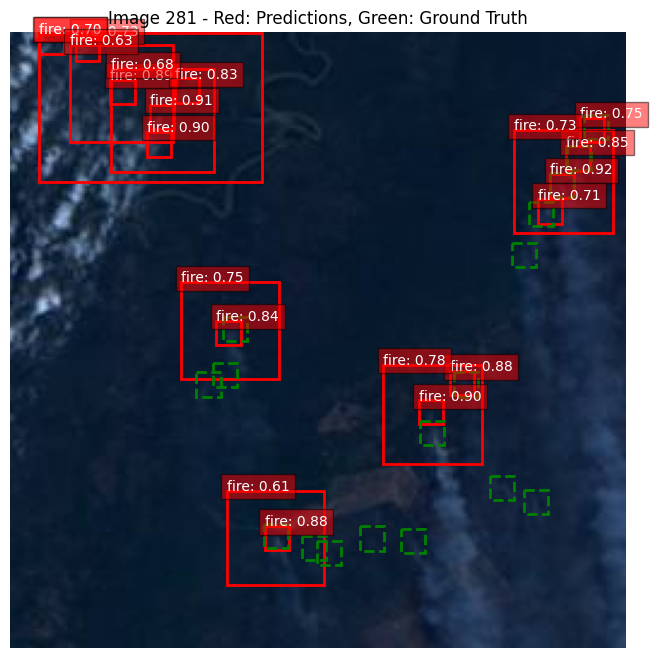

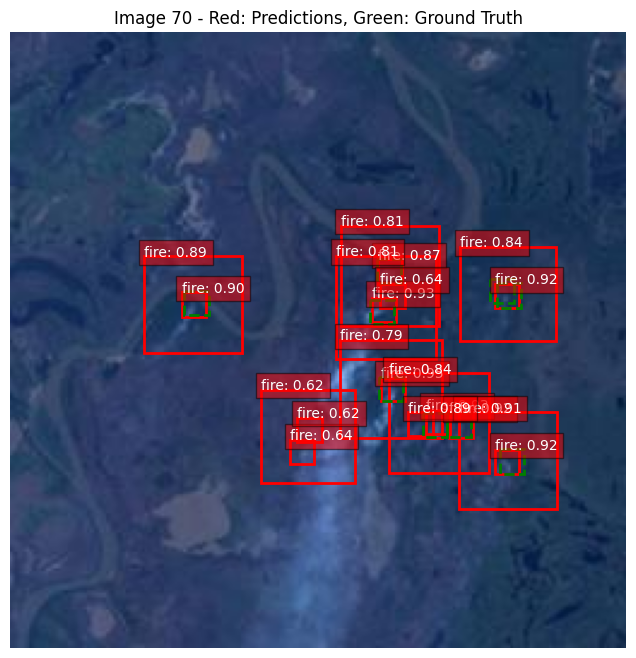

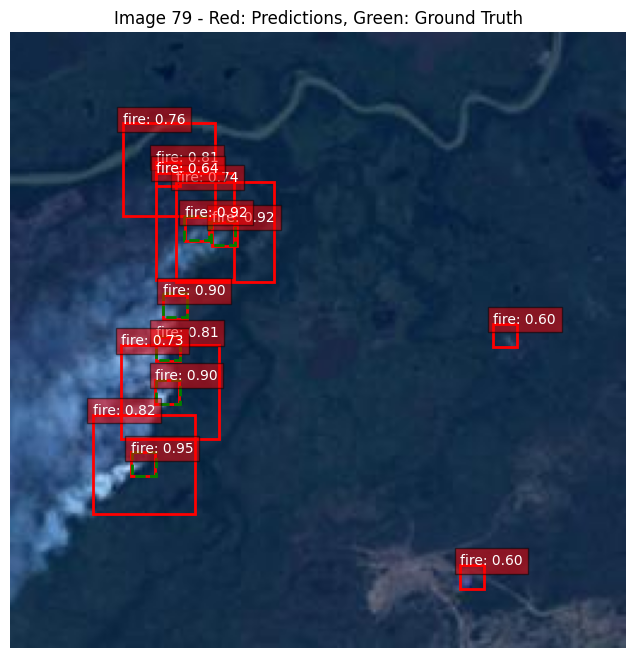

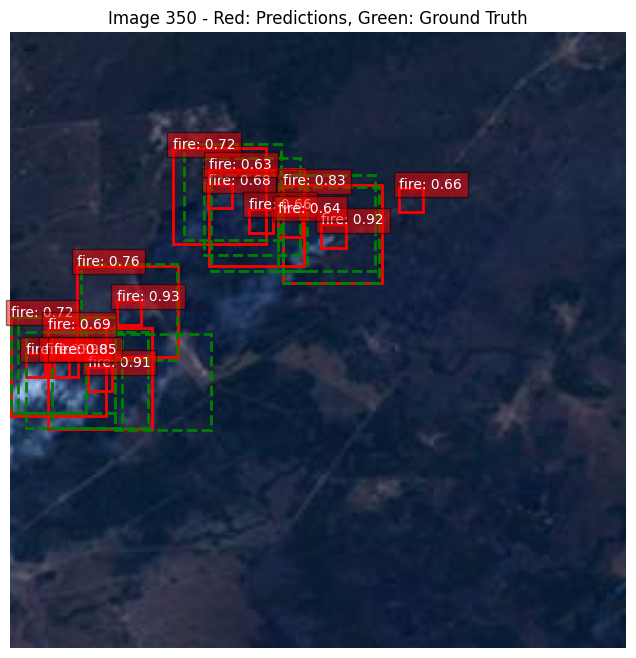

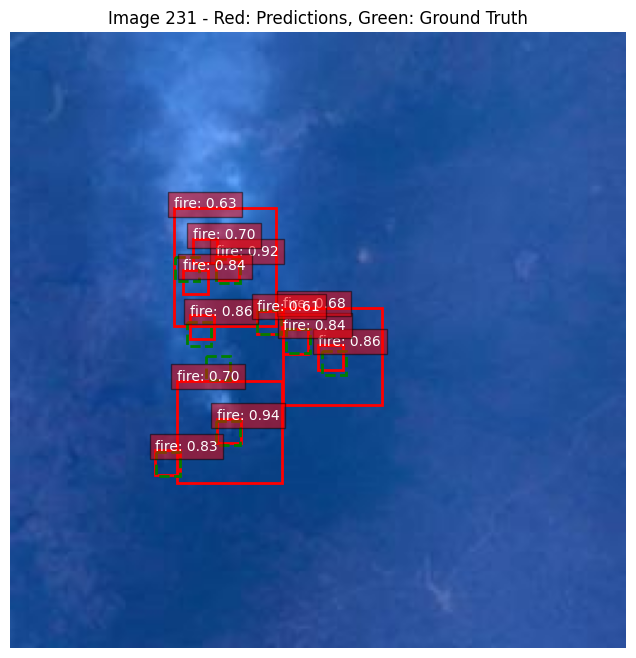

In [ ]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


threshold = 0.6
def predict_and_plot(model, dataset, device, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)
    
    model.eval()
    
    for idx in indices:
        img, target = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(img_tensor)[0]
        
        keep = prediction['scores'] > threshold
        boxes = prediction['boxes'][keep].cpu().numpy()
        scores = prediction['scores'][keep].cpu().numpy()
        
        img = F.to_pil_image(img) if isinstance(img, torch.Tensor) else img
        
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        ax = plt.gca()
        

        for box, score in zip(boxes, scores):
            if score > threshold: 
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle(
                    (xmin, ymin), xmax-xmin, ymax-ymin,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                ax.add_patch(rect)
                plt.text(
                    xmin, ymin, f'fire: {score:.2f}',
                    bbox=dict(facecolor='red', alpha=0.5),
                    fontsize=10, color='white'
                )
        
        if 'boxes' in target:
            for box in target['boxes']:
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle(
                    (xmin, ymin), xmax-xmin, ymax-ymin,
                    linewidth=2, edgecolor='g', facecolor='none',
                    linestyle='--'
                )
                ax.add_patch(rect)
        
        plt.title(f"Image {idx} - Red: Predictions, Green: Ground Truth")
        plt.axis('off')
        plt.show()


predict_and_plot(model, dataset_test, device, num_images=5)

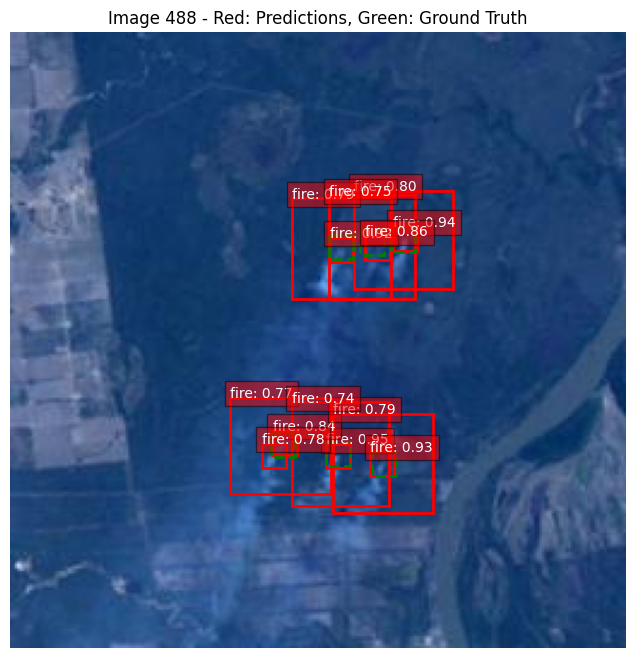

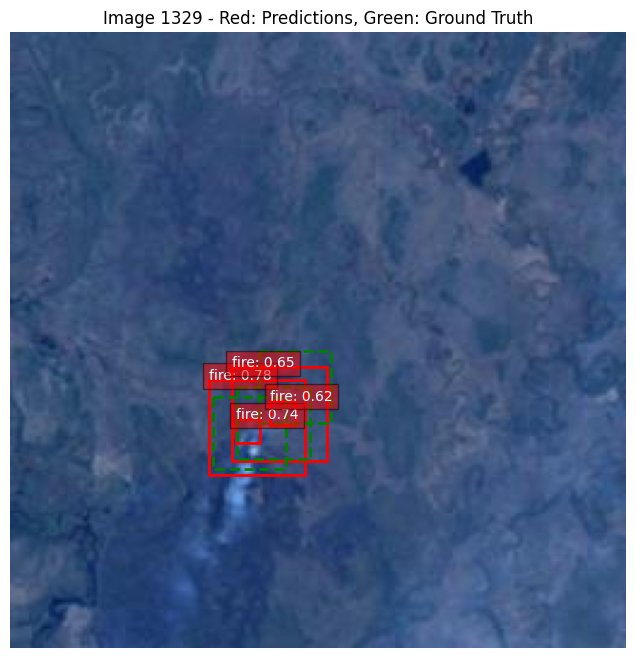

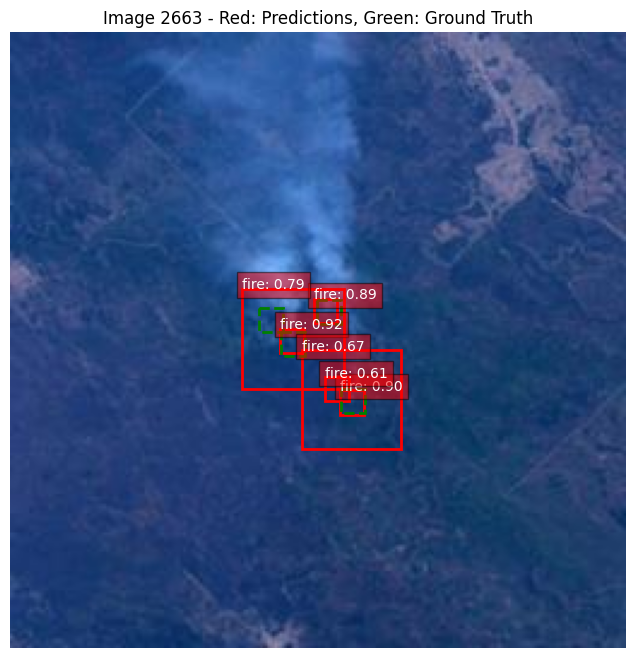

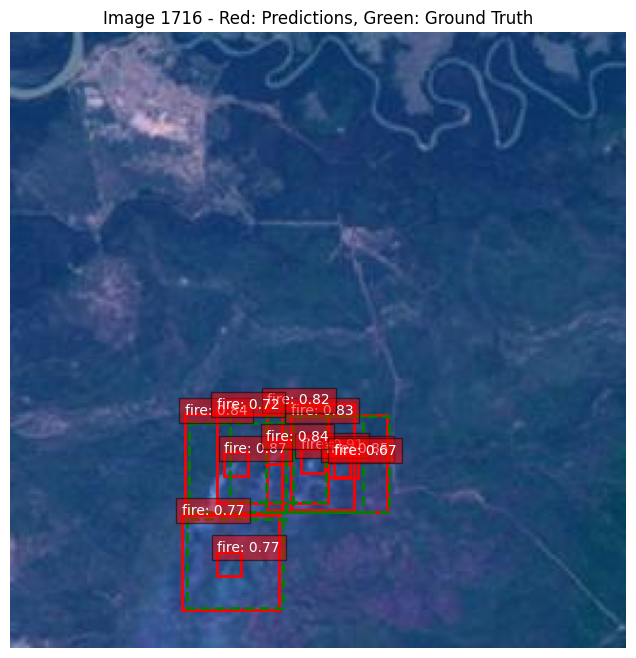

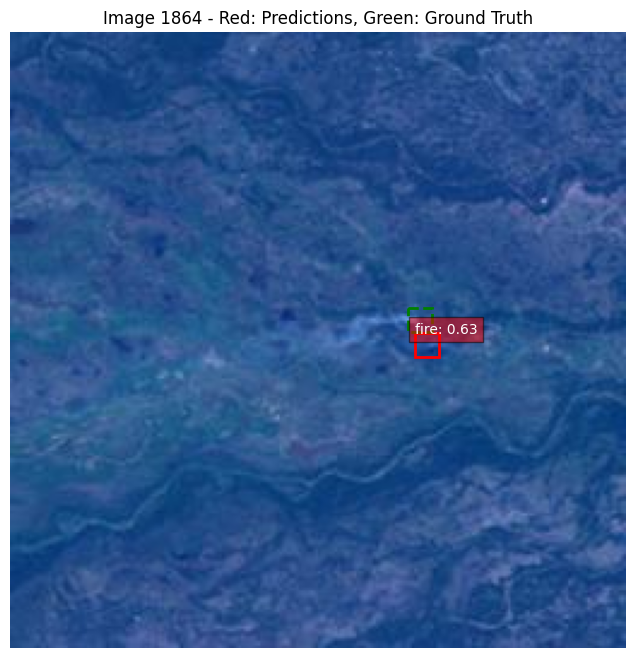

In [ ]:
predict_and_plot(model, dataset_train, device, num_images=5)